**Tải bộ dữ liệu**

In [61]:
!gdown --id 1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V

D:\Miniconda3\Lib\site-packages\gdown\__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V
To: d:\AIO2024\module_5\week_3\NonLinear_data.npy

  0%|          | 0.00/5.57k [00:00<?, ?B/s]
100%|██████████| 5.57k/5.57k [00:00<00:00, 2.79MB/s]


**Import các thư viện cần thiết**

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

**Cài đặt giá trị ngẫu nhiên cố định và thiết bị tính toán**

In [63]:
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_state)

**Đọc bộ dữ liệu**

In [64]:
dataset_path = 'NonLinear_data.npy'
data = np.load(dataset_path, allow_pickle=True).item()
X = data['X']
y = data['labels']
print(X.shape, y.shape)

(300, 2) (300,)


**Chia bộ dữ liệu train/val/test**

In [ ]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size,
                                                  random_state=random_state,
                                                  shuffle=is_shuffle)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                                    test_size=test_size,
                                                    random_state=random_state,
                                                    shuffle=is_shuffle)

**Chuẩn hóa đặc trưng đầu vào**

In [66]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

**Xây dựng DataLoader**

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [68]:
batch_size = 32

train_dataset = CustomDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CustomDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

**Xây dựng mạng MLP**

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        out = self.fc2(x)
        return out

In [70]:
input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = len(torch.unique(y_train))

model = MLP(input_dim, hidden_dim, output_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

**Khai báo hàm loss và optimizer**

In [71]:
lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

**Xây dựng hàm tính độ chính xác**

In [72]:
def compute_accuracy(y_pred, y_true):
    correct = (y_pred == y_true).sum().item()
    total = y_true.size(0)
    return correct / total

**Huấn luyện mô hình**

In [73]:
epochs = 100
train_losses = []
val_losses = []
train_acc = []
val_acc = []

for epoch in range(epochs):
    train_loss = 0
    train_target = []
    train_pred = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples, y_samples = X_samples.to(device), y_samples.to(device)
        optimizer.zero_grad()
        y_pred = model(X_samples)
        loss = criterion(y_pred, y_samples.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_target.extend(y_samples.tolist())
        train_pred.extend(torch.argmax(y_pred, dim=1).tolist())

    train_losses.append(train_loss / len(train_loader))
    train_pred = torch.tensor(train_pred)
    train_target = torch.tensor(train_target)
    train_acc.append(compute_accuracy(train_pred, train_target))

    val_loss = 0
    val_target = []
    val_pred = []

    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples, y_samples = X_samples.to(device), y_samples.to(device)
            y_pred = model(X_samples)
            loss = criterion(y_pred, y_samples.long())
            val_loss += loss.item()

            val_target.extend(y_samples.tolist())
            val_pred.extend(torch.argmax(y_pred, dim=1).tolist())

    val_losses.append(val_loss / len(val_loader))
    val_acc.append(compute_accuracy(torch.tensor(val_pred), torch.tensor(val_target)))

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}')

Epoch 1/100, Train Loss: 0.9386, Val Loss: 0.8641, Train Acc: 0.5381, Val Acc: 0.4833
Epoch 2/100, Train Loss: 0.7497, Val Loss: 0.8150, Train Acc: 0.5762, Val Acc: 0.3833
Epoch 3/100, Train Loss: 0.7150, Val Loss: 0.7986, Train Acc: 0.5762, Val Acc: 0.4833


Epoch 4/100, Train Loss: 0.6890, Val Loss: 0.7907, Train Acc: 0.6048, Val Acc: 0.4500
Epoch 5/100, Train Loss: 0.6696, Val Loss: 0.7799, Train Acc: 0.6048, Val Acc: 0.5167
Epoch 6/100, Train Loss: 0.6541, Val Loss: 0.7465, Train Acc: 0.6143, Val Acc: 0.5000
Epoch 7/100, Train Loss: 0.6455, Val Loss: 0.7235, Train Acc: 0.6476, Val Acc: 0.5333
Epoch 8/100, Train Loss: 0.6158, Val Loss: 0.7038, Train Acc: 0.6714, Val Acc: 0.5167
Epoch 9/100, Train Loss: 0.6165, Val Loss: 0.6935, Train Acc: 0.6667, Val Acc: 0.4833
Epoch 10/100, Train Loss: 0.6096, Val Loss: 0.6663, Train Acc: 0.6619, Val Acc: 0.5667
Epoch 11/100, Train Loss: 0.5769, Val Loss: 0.6660, Train Acc: 0.6762, Val Acc: 0.6000
Epoch 12/100, Train Loss: 0.5962, Val Loss: 0.6418, Train Acc: 0.6667, Val Acc: 0.6167
Epoch 13/100, Train Loss: 0.5557, Val Loss: 0.6249, Train Acc: 0.7095, Val Acc: 0.6333
Epoch 14/100, Train Loss: 0.5373, Val Loss: 0.6080, Train Acc: 0.7190, Val Acc: 0.6333
Epoch 15/100, Train Loss: 0.5206, Val Loss: 0.604

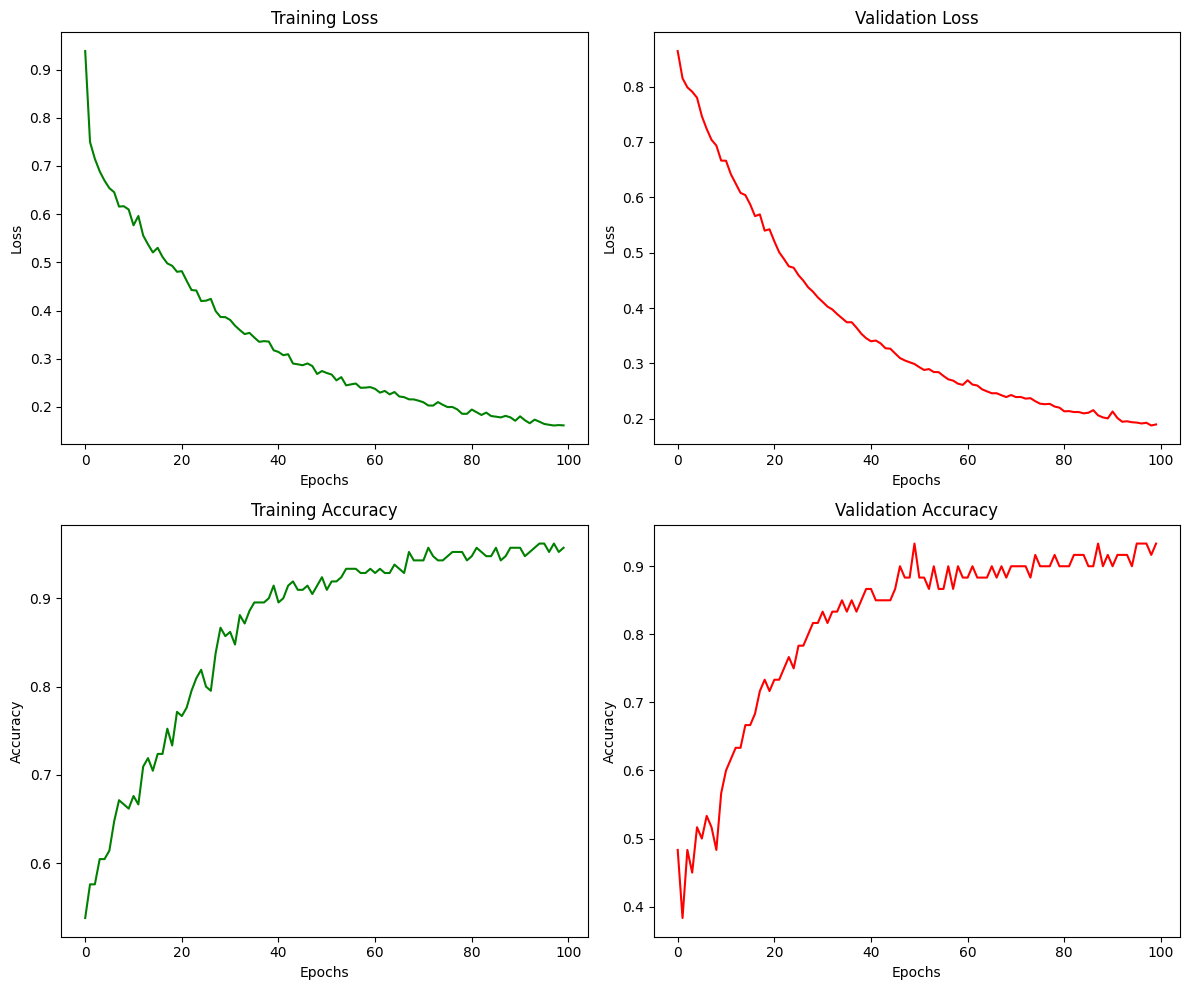

In [74]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='g')
ax[0, 0].set(xlabel='Epochs', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='r')
ax[0, 1].set(xlabel='Epochs', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc, color='g')
ax[1, 0].set(xlabel='Epochs', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc, color='r')
ax[1, 1].set(xlabel='Epochs', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.tight_layout()
plt.show()

**Đánh giá mô hình**

In [75]:
test_target = []
test_pred = []

model.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples, y_samples = X_samples.to(device), y_samples.to(device)
        y_pred = model(X_samples)

        test_target.extend(y_samples.tolist())
        test_pred.extend(torch.argmax(y_pred, dim=1).tolist())

    test_target = torch.tensor(test_target)
    test_pred = torch.tensor(test_pred)
    test_acc = compute_accuracy(test_pred, test_target)
    print(f'Test Accuracy: {test_acc:.4f}')


Test Accuracy: 0.9333
